# Single Cell RNA-Sequencing data and gene relevance

## Libraries

We need of course destiny, scran for preprocessing, and some tidyverse niceties.

In [114]:
library(conflicted)
library(destiny)
suppressPackageStartupMessages(library(scran))
library(purrr)
library(ggplot2)

## Data

Let’s use data from the `scRNAseq`[1] package. If necessary, install it via `BiocManager::install('scRNAseq')`.

[1] Risso D, Cole M (2019). [scRNAseq: A Collection of Public Single-Cell RNA-Seq Datasets](https://bioconductor.org/packages/scRNAseq/).

In [8]:
# The parts of the help we’re interested in
help('scRNAseq-package', package = 'scRNAseq') %>% repr::repr_html() %>%
    stringr::str_extract_all(stringr::regex('<p>The dataset.*?</p>', dotall = TRUE)) %>% unlist() %>%
    paste(collapse = '') %>% IRdisplay::display_html()

The dataset fluidigm contains 65 cells from Pollen et al. (2014), each sequenced at high and low coverage.
 The dataset th2 contains 96 T helper cells from Mahata et al. (2014).
 The dataset allen contains 379 cells from the mouse visual cortex. This is a subset of the data published in Tasic et al. (2016).

379 cells seems sufficient to see something!

In [136]:
data('allen', package = 'scRNAseq')

## Preprocessing

We’ll mostly stick to the [scran vignette][] here. Let’s add basic information to the data and choose what to work with.

As `scran` expects the raw counts in the `counts` assay, we rename the more accurate RSEM counts to `counts`:

[scran vignette]: https://bioconductor.org/packages/devel/bioc/vignettes/scran/inst/doc/scran.html

In [137]:
allen <- as(allen, 'SingleCellExperiment')
rowData(allen)$Symbol <- rownames(allen)
rowData(allen)$EntrezID <- AnnotationDbi::mapIds(org.Mm.eg.db::org.Mm.eg.db, rownames(allen), 'ENTREZID', 'ALIAS')
rowData(allen)$Uniprot <- AnnotationDbi::mapIds(org.Mm.eg.db::org.Mm.eg.db, rownames(allen), 'UNIPROT', 'ALIAS', multiVals = 'list')
assayNames(allen)[assayNames(allen) == 'rsem_counts'] <- 'counts'
isSpike(allen, 'ERCC') <- grepl('^ERCC-', rownames(allen))
allen

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



class: SingleCellExperiment 
dim: 20908 379 
metadata(2): SuppInfo which_qc
assays(4): tophat_counts cufflinks_fpkm counts rsem_tpm
rownames(20908): 0610007P14Rik 0610009B22Rik ... Zzef1 Zzz3
rowData names(3): Symbol EntrezID Uniprot
colnames(379): SRR2140028 SRR2140022 ... SRR2139341 SRR2139336
colData names(22): NREADS NALIGNED ... Animal.ID passes_qc_checks_s
reducedDimNames(0):
spikeNames(1): ERCC

Now we can use it to renormalize the data. We normalize the `counts` using the spike-in size factors and logarithmize them into `logcounts`.

In [138]:
allen <- computeSpikeFactors(allen)
allen <- normalize(allen)

We also use the spike-ins to detect highly variable genes more accurately:

In [139]:
decomp <- decomposeVar(allen, trendVar(allen, parametric = TRUE))
rowData(allen)$hvg_order <- order(decomp$bio, decreasing = TRUE)

We create a subset of the data containing only rasonably highly variable genes and no spike-ins:

In [140]:
allen_hvg <- subset(allen, hvg_order <= 5000L & !isSpike(allen))

Let’s create a Diffusion map. For rapid results, people often create a PCA first, which can be stored in your `SingleCellExperiment` before creating the Diffusion map or simply created implicitly using `DiffusionMap(..., n_pcs = <number>)`.

However, even with many more principal components than necessary to get a nicely resolved Diffusion Map, the close spatial correspondence between diffusion components and genes are lost.

In [75]:
#reducedDim(allen_hvg, 'pca') <- irlba::prcomp_irlba(t(assay(allen, 'logcounts')), 50)$x

The chosen distance metric has big implications on your results, you should try at least cosine and rankcor.

In [76]:
set.seed(1)
dms <- c('euclidean', 'cosine', 'rankcor') %>% #, 'l2'
    set_names() %>%
    map(~ DiffusionMap(allen_hvg, distance = ., knn_params = list(method = 'covertree')))

Warning message in DiffusionMap(allen_hvg, distance = ., knn_params = list(method = "covertree")):
“You have 4972 genes. Consider passing e.g. n_pcs = 50 to speed up computation.”
Warning message in DiffusionMap(allen_hvg, distance = ., knn_params = list(method = "covertree")):
“You have 4972 genes. Consider passing e.g. n_pcs = 50 to speed up computation.”
Warning message in DiffusionMap(allen_hvg, distance = ., knn_params = list(method = "covertree")):
“You have 4972 genes. Consider passing e.g. n_pcs = 50 to speed up computation.”


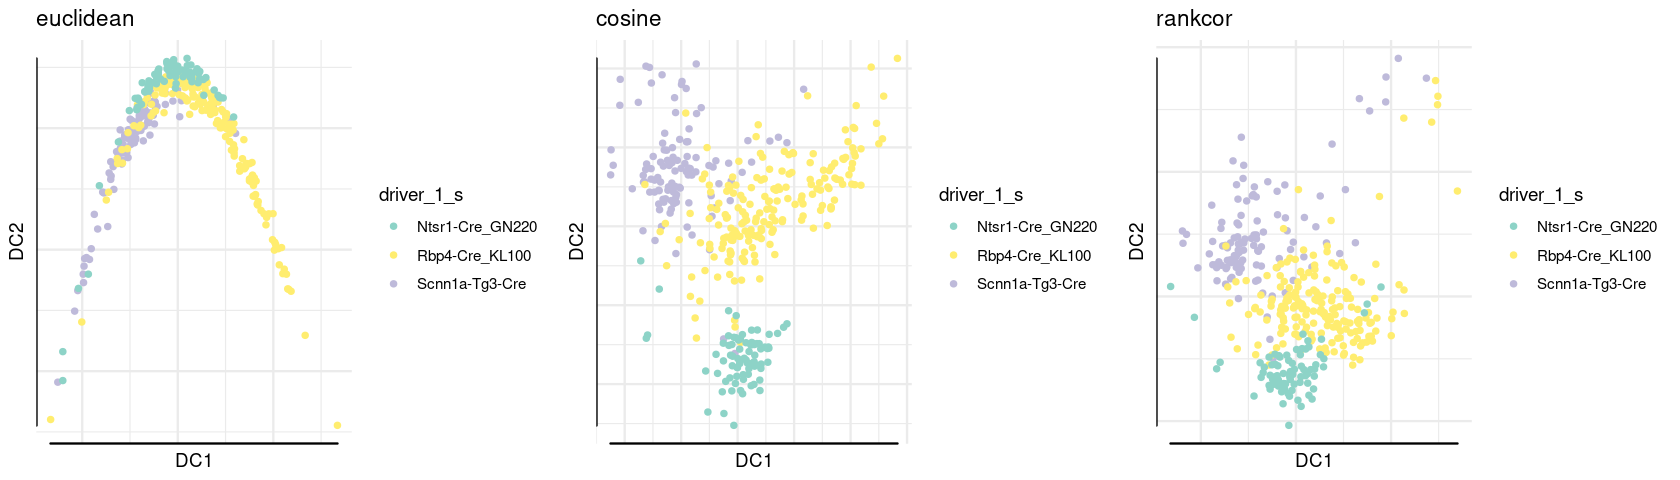

In [77]:
options(repr.plot.width = 14, repr.plot.height = 4)
dms %>%
    imap(function(dm, dist) plot(dm, 1:2, col_by = 'driver_1_s') + ggtitle(dist)) %>%
    cowplot::plot_grid(plotlist = ., nrow = 1)

In [78]:
grs <- map(dms, gene_relevance)

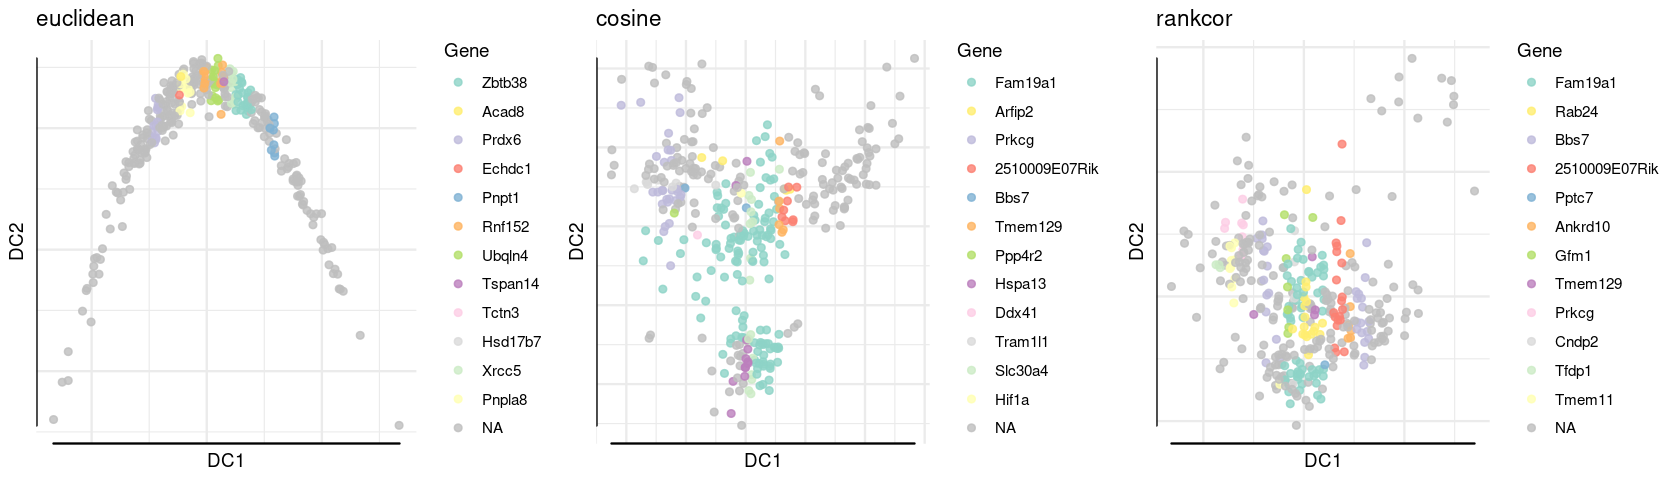

In [79]:
options(repr.plot.width = 14, repr.plot.height = 4)
gms <- imap(grs, function(gr, dist) plot(gr, iter_smooth = 0) + ggtitle(dist))
cowplot::plot_grid(plotlist = gms, nrow = 1)

As you can see, despite the quite different embedding, the rankcor and Cosine diffusion Maps display a number of the same driving genes.

In [116]:
gms[-1] %>% map(~ .$ids[1:10]) %>% purrr::reduce(intersect) %>% cat(sep = ' ')

Fam19a1 Prkcg 2510009E07Rik Bbs7 Tmem129

In [176]:
httr::GET('https://www.uniprot.org/uniprot/', query = list(
    columns = 'id,genes,comment(TISSUE SPECIFICITY)',
    format = 'tab',
    query = rowData(allen)$Uniprot[gms$cosine$ids[1:6]] %>% unlist() %>% paste(collapse = ' or ')
)) %>% httr::content(type = 'text/tab-separated-values', encoding = 'utf-8', )

Parsed with column specification:
cols(
  Entry = col_character(),
  `Gene names` = col_character(),
  `Tissue specificity` = col_character()
)



Entry,Gene names,Tissue specificity
<chr>,<chr>,<chr>
Q8K221,Arfip2,NA
Q6GQU0,NA,NA
Q7TPG8,Tafa1 Fam19a1,TISSUE SPECIFICITY: Expressed in the hippocampus and detected also in the cortex (at protein level). {ECO:0000269|PubMed:29799787}.
Q8K304,Tmem129,NA
P63318,Prkcg Pkcc Pkcg Prkcc,"TISSUE SPECIFICITY: Expressed in the cerebellum, cerebral cortex and hippocampus (at protein level). Highly expressed in Purkinje cells. {ECO:0000269|PubMed:17904530, ECO:0000269|PubMed:23185022}."
Q8K2G4,Bbs7 Bbs2l1,NA
Q2NKI4,Prkcg Prkcc,NA
A0A1B0GSM3,Arfip2 mCG_19713,NA
Q3UN66,Prkcg Prkcc mCG_18472,NA
